In [2]:
from helpers import load_hdf5

In [16]:
# train_x, train_y, test_x, test_y = load_hdf5('data_v2.h5')
# train_x, train_y, test_x, test_y = load_hdf5('data.h5')
train_x, train_y, test_x, test_y = load_hdf5('data_big.h5')

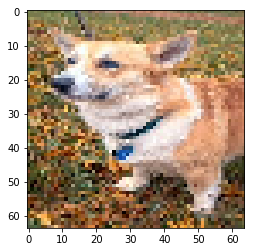

In [18]:
%matplotlib inline
import matplotlib.pyplot as plt

img = test_x[11]
plt.imshow(img)
plt.show()

In [19]:
import numpy as np

'''
Transform shape of data from (250, 64, 64, 3) to (12288, 250)
- represent each image as column vector ! (12288, 1)
'''

flat_train_x = np.zeros(shape=(np.prod(train_x.shape[1:]), train_x.shape[0]))
flat_test_x = np.zeros(shape=(np.prod(test_x.shape[1:]), test_x.shape[0]))

for i, sample in enumerate(train_x):
    flat_train_x[:, i] = sample.flatten()
    
for i, sample in enumerate(test_x):
    flat_test_x[:, i] = sample.flatten()
        
'''
Two ways of simple normalization of data at the beginning.
'''

# flat_train_x /= 255.0
# flat_test_x /= 255.0

flat_train_x = (flat_train_x - np.mean(flat_train_x)) / np.std(flat_train_x)
flat_test_x = (flat_test_x - np.mean(flat_test_x)) / np.std(flat_test_x)

'''
Convert from original uint to float just-in-case.
'''
train_y_float = np.array(train_y, dtype=np.float64)
test_y_float = np.array(test_y, dtype=np.float64)


In [20]:
def sigmoid(z):
    return 1.0 / (1.0 + np.exp(-z))

def d_sigmoid(a):
    return a * (1-a)

def tanh(z):
    return np.tanh(z)

def d_tanh(a):
    return 1 - np.square(a)

def relu(z):
    return np.maximum(0, z)

def d_relu(a):
    return np.int64(a > 0)

'''
Functions below are responsible for choosing the right function above. :)
'''
def activate(z, method='sigmoid'):
    if method == 'sigmoid':
        return sigmoid(z)
    elif method == 'tanh':
        return tanh(z)
    elif method == 'relu':
        return relu(z)
    else:
        print("Method {} is unknown!".format(method))
    
def derive(a, method='sigmoid'):
    if method == 'sigmoid':
        return d_sigmoid(a)
    elif method == 'tanh':
        return d_tanh(a)
    elif method == 'relu':
        return d_relu(a)
    else:
        print("Method {} is unknown!".format(method))

In [21]:
epsilon = 1e-5  

def loss(output, y):
    m = y.shape[0]
    
    logprobs = -y * np.log(output+epsilon) - (1-y) * np.log(1 - output+epsilon)
    cost = 1.0/m * np.sum(logprobs)

    return cost

'''
Same as original loss function, but with regularization based on weights.
(lambda is 0.1 by default)
'''
def new_loss(output, y, weights, lambda_value=0.1):
    m = y.shape[0]
    w_sum = 0.0
    for w in weights:
        w_sum += np.sum(np.square(weights[w]))
    return loss(output, y) + (lambda_value / (2*m)) * w_sum

In [22]:
from helpers import init_weights
from helpers import get_labels, get_d_labels

In [41]:
'''
Here we can define our model.
Different sets of hidden layers are stored in layers array, which is an array of dict:
'units' - to tell how many units are in each hidden layer,
'activations' - to tell which activation function we would like to use on each layer; 
we also put output activation function at the end
'''

num_iters = 5000
m = float(train_y.shape[0])

models = []
loss_array = []

input_size = flat_train_x.shape[0]
output_size = 1

layers = [
#          {'units' : [50], 
#           'activations' : ['tanh', 'sigmoid']},
          {'units' : [80, 40, 20], 
          'activations' : ['tanh', 'tanh', 'tanh', 'sigmoid']},
          {'units' : [200, 100, 80, 40, 20], 
          'activations' : ['relu', 'relu', 'relu', 'relu', 'relu', 'sigmoid']},
          {'units' : [2000, 1500, 1000, 700, 400, 200, 100, 80, 40, 20], 
          'activations' : ['relu']*10 + ['sigmoid']}
         ]

'''
Regularization parameters
If equal to 0.0, then this regularization method is omitted.
'''

l2_lambda = 0.0
dropout = 0.0

'''
Learning rate
'''
alpha = 0.01

In [42]:
m = float(train_y.shape[0])

for l2_lambda in [0.0, 0.5, 1.0, 3.0, 10.0]:
# for meth in ['random', 'xavier', 'he']:

    for version_idx, layer in enumerate(layers[:1]):

        activation_methods = layer['activations']
        hidden_layers = layer['units']

        print('\n', hidden_layers)

        weights, bias = init_weights(input_size, hidden_layers, output_size, 
                                     method='he')
    #     for b in bias:
    #         bias[b] += 0.01
    #     (non-zero bias)

        loss_subarray = []

        for i in range(num_iters):

            activations = {}
            if dropout:
                dropouts = {}

            # propagate FORWARD:

            for idx in range(1, len(weights.keys())+1):

                W_label, b_label, A_label, A_prev_label = get_labels(idx)

                W = weights[W_label]
                b = bias[b_label]

                if idx == 1:
                    Z = W.dot(flat_train_x) + b
                else:
                    A_prev = activations[A_prev_label]
                    Z = W.dot(A_prev) + b

                A = activate(Z, method=activation_methods[idx-1])

                if dropout and idx != len(weights.keys()):
                    mask = (np.random.rand(A.shape[0], A.shape[1]) > dropout) * 1.0
                    A = A * mask
                    A = A / (1.0-dropout)

                    D_label = 'D{}'.format(idx)
                    dropouts[D_label] = mask

                activations[A_label] = A

                if idx == len(weights.keys()):
                    if i % 100 == 0:
                        J = new_loss(A, train_y_float, weights)
                        J_old = loss(A, train_y_float)
                        print(J, J_old)
                        loss_subarray.append([J, J_old])

            derivatives = {}

            # propagate BACKWARD:

            for idx in range(len(weights.keys()), 0, -1):

                dA_label, dZ_label, dW_label, db_label = get_d_labels(idx)
                current_W = weights['W{}'.format(idx)]

                A = activations[dA_label[1:]]
                if idx == len(weights.keys()):
                    dA = A - train_y
                    dZ = dA
                else:
                    W = weights['W{}'.format(idx+1)]
                    dZ_next = derivatives['dZ{}'.format(idx+1)]

                    dA = np.dot(W.T, dZ_next)
                    if dropout:
                        D_label = 'D{}'.format(idx)
                        if D_label in dropouts.keys():
                            dA = np.multiply(dropouts[D_label], dA)

                    dZ = dA * derive(A, method=activation_methods[idx-1])

                if activation_methods[idx-1] == 'relu':
                    dZ = np.multiply(dA, np.float32(A > 0))

                if idx == 1:
                    dW = np.dot(dZ, flat_train_x.T)
                else:
                    dW = np.dot(dZ, activations['A{}'.format(idx-1)].T)
 
                dW *= (1/m)
                db = np.sum(dZ) * (1/m)

                if l2_lambda != 0.0:
                    dW += (l2_lambda/m) * current_W

                derivatives[dA_label] = dA
                derivatives[dZ_label] = dZ
                derivatives[dW_label] = dW
                derivatives[db_label] = db

                weights[dW_label[1:]] += -alpha * dW
                bias[db_label[1:]] += -alpha * db

        models.append([version_idx, weights, bias, dropout])
        loss_array.append([version_idx, loss_subarray])
        print("Added model {}!".format(version_idx))



 [80, 40, 20]
0.7401364596351312 0.7345088129199261
0.4640397885609298 0.45840281787296927
0.36957352158351753 0.3639166646803287
0.27824452565172747 0.2725644619212217
0.19936860587044003 0.19366480890851592
0.12156629603376767 0.11584085788494734
0.08541026914798054 0.07966780883521456
0.06278730608807462 0.057030616302828914
0.04835062956895946 0.042582118161434486
0.03882992824284285 0.033051519134519695
0.032263618399693446 0.026476805752053554
0.027559404187372575 0.021765351478813144
0.024081750762051525 0.018281376693165163
0.021440162916254515 0.015634204144053122
0.01938418250206278 0.013573237976109586
0.01775144615678341 0.011936009294774076
0.016433837206417196 0.010614319927813027
0.015354288806153919 0.009531039187566884
0.014456778437287085 0.008630093580466635
0.013700752627902407 0.007870888449933366
0.013056521111679688 0.007223699957442199
0.01250195570052589 0.00666637229116115
0.012020271393373246 0.006182097503680081
0.011598531266188868 0.005757919434930755
0.0

0.008260191954628059 0.0029441230997774015
0.008183767932563387 0.0028790391711329077
0.008110814854745234 0.00281742464546186
0.008041076249355426 0.002759021772354803
0.00797432006736622 0.0027035973159809756
Added model 0!

 [80, 40, 20]
0.8189726969321518 0.8134222090011487
0.4517299207283102 0.44621450709108196
0.351471060187239 0.34597857072076976
0.25409411863777676 0.24862139200622624
0.17349474569018752 0.16804151923404592
0.10404754276452031 0.0986167723646596
0.0711011311259543 0.06569641838962739
0.05344153922305317 0.048066086790372074
0.04229626072605478 0.03695207369976803
0.034901038091953364 0.02958958810497286
0.029762416748290586 0.024484759536395718
0.02604320912022147 0.0208000935136871
0.023256431868615337 0.018048382561116114
0.02110652607032003 0.015933902814024136
0.019406676636948547 0.014269716072456171
0.0180343571021171 0.012933202510879803
0.01690651375791865 0.011841236516440447
0.01596519080289505 0.010935806104705887
0.015168905231062162 0.0101753837988

In [34]:
models = models[3:]
loss_array = loss_array[3:]

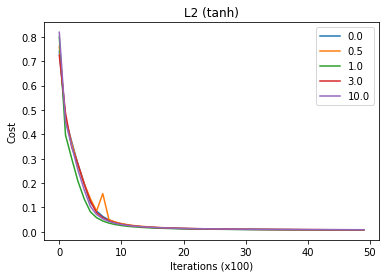

In [45]:
for l in loss_array:
    losses = [result[0] for result in l[1]]
    plt.plot(np.arange(len(losses)), losses)

plt.xlabel('Iterations (x100)')
plt.ylabel('Cost')
plt.title('L2 (tanh)')
plt.legend([0.0, 0.5, 1.0, 3.0, 10.0])
# plt.show()

plt.savefig('l2.pdf')

In [46]:
def predict(samples, answers, layers, output_size, weights, bias):

    activation_methods = layer['activations']
    hidden_layers = layer['units']

    activations = {}

    for idx in range(1, len(weights.keys())+1):

        W_label, b_label, A_label, A_prev_label = get_labels(idx)

        W = weights[W_label]
        b = bias[b_label]

        if idx == 1:
            Z = W.dot(samples) + b
        else:
            A_prev = activations[A_prev_label]
            Z = W.dot(A_prev) + b

        A = activate(Z, method=activation_methods[idx-1])
        activations[A_label] = A
        
    acc = analyze(A.T, answers)
    
    print()
    
for m in models:
    idx = m[0]
    print("TRAIN SET:")
    predict(flat_train_x, train_y, layers[idx], 1, m[1], m[2])    
    print("TEST SET:")
    predict(flat_test_x, test_y, layers[idx], 1, m[1], m[2])    


TRAIN SET:
Confusion matrix:
[[1250    0]
 [   0 1250]]
Accuracy: 1.0

TEST SET:
Confusion matrix:
[[142 108]
 [115 135]]
Accuracy: 0.554

TRAIN SET:
Confusion matrix:
[[1250    0]
 [   0 1250]]
Accuracy: 1.0

TEST SET:
Confusion matrix:
[[139 111]
 [109 141]]
Accuracy: 0.56

TRAIN SET:
Confusion matrix:
[[1250    0]
 [   0 1250]]
Accuracy: 1.0

TEST SET:
Confusion matrix:
[[131 119]
 [103 147]]
Accuracy: 0.556

TRAIN SET:
Confusion matrix:
[[1250    0]
 [   0 1250]]
Accuracy: 1.0

TEST SET:
Confusion matrix:
[[136 114]
 [110 140]]
Accuracy: 0.552

TRAIN SET:
Confusion matrix:
[[1250    0]
 [   0 1250]]
Accuracy: 1.0

TEST SET:
Confusion matrix:
[[133 117]
 [110 140]]
Accuracy: 0.546



In [28]:
from sklearn.metrics import confusion_matrix

def analyze(output, y):
    
#     J = loss(output, y).mean()
    
    output[output < 0.5] = 0.0
    output[output >= 0.5] = 1.0
    
    cf = confusion_matrix(y, output)
    tn, fp, fn, tp = cf.ravel()
    acc = (tp+tn)/np.sum(cf)
#     print('Confusion matrix:\n{}\nAccuracy: {}, Loss: {}'.format(cf, acc, J))
    print('Confusion matrix:\n{}\nAccuracy: {}'.format(cf, acc))
    
    return acc
    